In [1]:
# %env CUDNN_PATH /home/arch/.pyenv/versions/evo/lib/python3.11/site-packages/nvidia/cudnn
# %env LD_LIBRARY_PATH /home/arch/.pyenv/versions/evo/lib/python3.11/site-packages/nvidia/cudnn/lib:/home/arch/.pyenv/versions/evo/lib/python3.11/site-packages/tensorrt_libs/
# # %env TF_ENABLE_ONEDNN_OPTS=0


### Autoencoders with CIFAR-10

In [2]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy, mse

(x_train, y_trainclass), (x_test, y_testclass) = cifar10.load_data()

2024-05-19 21:04:59.105085: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-19 21:05:00.025703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[28310 38047 41669 19014 16294]


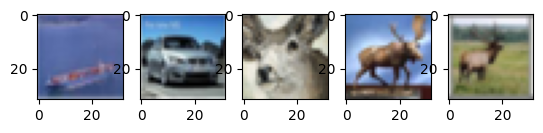

In [5]:
def plotn(n, x):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(x[0:n]):
        ax[i].imshow(z)
    plt.show()

def plotidx(indices, x):
    fig, ax = plt.subplots(1, len(indices))
    for i, z in enumerate(x[indices]):
        ax[i].imshow(z)
    plt.show()

ids = np.random.randint(len(x_train), size=5)
print(ids)
plotidx(ids,x_train)

In [6]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Denoising

In [7]:
input_img = Input(shape=(32,32,3))

x = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

encoder = Model(input_img, encoded)

input_rep = Input(shape=(4,4,64))

x = Conv2D(64, (3,3), activation='relu', padding='same')(input_rep)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

decoder = Model(input_rep, decoded)

autoencoder_denoise = Model(input_img, decoder(encoder(input_img)))
autoencoder_denoise.compile(optimizer='adam', loss='binary_crossentropy')

2024-05-19 21:05:01.857935: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2793 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


[37195 19614  4299  9119  9845]
before adding noises


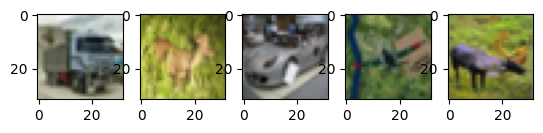

after adding noises


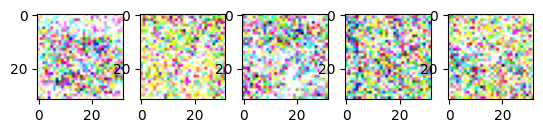

In [8]:
def noisify(data):
  return np.clip(data+np.random.normal(loc=0.5,scale=0.5,size=data.shape),0.,1.)

x_train_noise = noisify(x_train)
x_test_noise = noisify(x_test)

ids = np.random.randint(len(x_train_noise), size=5)
print(ids)
print("before adding noises")
plotidx(ids,x_train)
print("after adding noises")
plotidx(ids,x_train_noise)

In [9]:
autoencoder_denoise.fit(x_train_noise, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noise, x_test))

Epoch 1/25


I0000 00:00:1716127510.280613  125105 service.cc:145] XLA service 0x734f00026840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1716127510.280650  125105 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2024-05-19 21:05:10.337603: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-19 21:05:10.581130: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 10/391 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.6914

I0000 00:00:1716127513.203014  125105 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_1', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1716127513.205729  125105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.6252

I0000 00:00:1716127522.391894  125102 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_1', 8 bytes spill stores, 8 bytes spill loads



391/391 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 0.6251 - val_loss: 0.5912
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.5895 - val_loss: 0.5892
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.5856 - val_loss: 0.5872
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.5843 - val_loss: 0.5839
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.5829 - val_loss: 0.5831
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.5826 - val_loss: 0.5824
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.5816 - val_loss: 0.5818
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.5805 - val_loss: 0.5814
Epoch 9/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.5812 - val_loss: 0.5821
Epoch 10/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.5803 - val_loss: 0.5814
Epoch 11/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.5798 - val_loss: 0.5801
Epoch 12/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/st

[ 880 9313 6325 8467 1517]
input


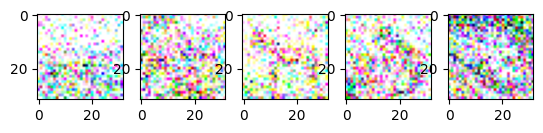

prediction


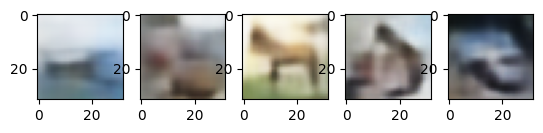

label


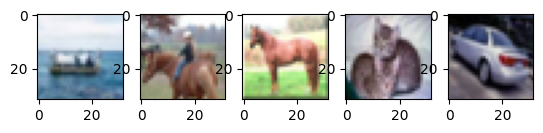

In [10]:
ids = np.random.randint(len(x_test_noise), size=5)
print(ids)
y_test = autoencoder_denoise.predict(x_test_noise[ids], verbose=False)
print("input")
plotidx(ids,x_test_noise)
print("prediction")
plotn(5,y_test )
print("label")
plotidx(ids,x_test)

# Super-resolution

[18182 35471 13209  5893  1557]
before downsample


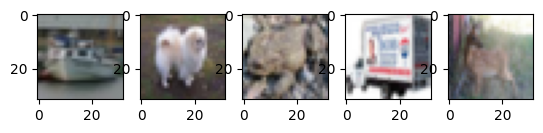

after downsample


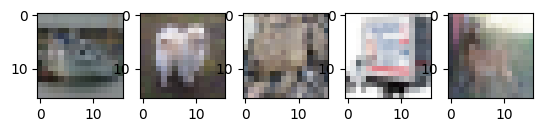

In [11]:
x_train_lr = tf.keras.layers.AveragePooling2D(2)(x_train).numpy()
x_test_lr = tf.keras.layers.AveragePooling2D(2)(x_test).numpy()

ids = np.random.randint(len(x_train), size=5)
print(ids)
print("before downsample")
plotidx(ids, x_train)
print("after downsample")
plotidx(ids, x_train_lr)

In [12]:
input_img = Input(shape=(16, 16, 3))

x = Conv2D(64, (3,3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2,2), padding='same')(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2,2), padding='same')(x)

encoder = Model(input_img, encoded)

input_rep = Input(shape=(4,4,64))

x = Conv2D(64, (3,3), activation='relu', padding='same')(input_rep)
x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
decoded = Conv2D(3, (3,3), activation='sigmoid', padding='same')(x)

decoder = Model(input_rep, decoded)

autoencoder_sr = Model(input_img, decoder(encoder(input_img)))
autoencoder_sr.compile(optimizer='adam', loss='binary_crossentropy')

In [13]:
autoencoder_sr.fit(x_train_lr, x_train,
               epochs=25,
               batch_size=128,
               shuffle=True,
               validation_data=(x_test_lr, x_test))

Epoch 1/25
 13/391 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.6854

I0000 00:00:1716127709.407592  125106 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_1', 8 bytes spill stores, 8 bytes spill loads



391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6156

I0000 00:00:1716127715.122124  125104 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_1', 8 bytes spill stores, 8 bytes spill loads



391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.6155 - val_loss: 0.5781
Epoch 2/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5748 - val_loss: 0.5726
Epoch 3/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5711 - val_loss: 0.5704
Epoch 4/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5687 - val_loss: 0.5682
Epoch 5/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5667 - val_loss: 0.5687
Epoch 6/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5661 - val_loss: 0.5659
Epoch 7/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5658 - val_loss: 0.5655
Epoch 8/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.5649 - val_loss: 0.5647
Epoch 9/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.5638 - val_loss: 0.5676
Epoch 10/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.5641 - val_loss: 0.5637
Epoch 11/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.5635 - val_loss: 0.5636
Epoch 12/25
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/ste

[6326 1357 9349 1082 7829]
input


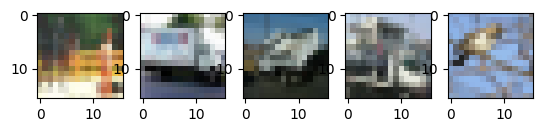

prediction


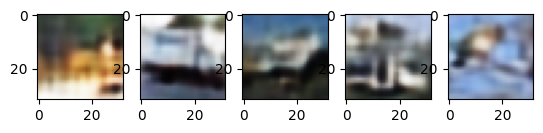

label


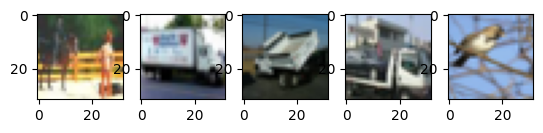

In [14]:
ids = np.random.randint(len(x_test_lr), size=5)
print(ids)
y_test_lr = autoencoder_sr.predict(x_test_lr[ids], verbose=False)
print("input")
plotidx(ids, x_test_lr)
print("prediction")
plotn(5, y_test_lr)
print("label")
plotidx(ids, x_test)